# XGBoost for Sink Particles
> Created Jan. 2025 <br>
> Nikhil Bisht<br>

In [42]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
import xgboost as xgb

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.dict'

IMAGESIZE = 128

#In percentage
NTRAIN_percentage =  0.8
NVALID_percentage =  0.05
NTEST_percentage  =  0.15

#ALL_COLUMNS = ['Initial_Frame', 'Particle_id', 'X_i', 'Y_i', 'Z_i', 'Vx_i', 'Vy_i', 'Vz_i', 'Density_i', 'X_f', 'Y_f', 'Z_f', 'Vx_f', 'Vy_f', 'Vz_f', 'Density_f']
#FEATURES = ALL_COLUMNS[0:9]
#TARGET = ALL_COLUMNS[9:]

ALL_COLUMNS = ['Initial_Frame', 'Particle_id', 'X_i', 'Y_i', 'Z_i', 'X_f', 'Y_f', 'Z_f']
FEATURES = ALL_COLUMNS[0:5]
TARGET = ALL_COLUMNS[5:]

FRAMES = np.arange(20,60, 4)
FRAME_DIFF = 30

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load data

In [47]:
#get core stuff
df_core_pids =[]
with h5py.File(CORESET, 'r') as f:
    tm = f['track_manager']
    df_core_pids = tm['particle_ids'][()]

#get data and prepare sample
df_timeseries_core = pd.DataFrame([], columns=ALL_COLUMNS)
df_timeseries_noncore = pd.DataFrame([], columns=ALL_COLUMNS)
f =  h5py.File(DATAFILE, 'r')
for frame_num_index in range(len(FRAMES)):
    frame_num = FRAMES[frame_num_index]
    print(frame_num)
    temp_df_timeseries = pd.DataFrame([], columns=FEATURES)
    temp_final_df = pd.DataFrame([], columns=['Particle_id', cname+'_f'])
    f_frame_ini = f[str(frame_num)]
    f_frame_fin = f[str(frame_num+FRAME_DIFF)]
    temp_df_timeseries['Initial_Frame'] = np.repeat(frame_num, len(f_frame_ini['Particle_id'][()]))
    temp_df_timeseries['Particle_id'] = f_frame_ini['Particle_id'][()]
    temp_df_timeseries['Particle_id'] = temp_df_timeseries['Particle_id'].astype('int32')
    temp_df_timeseries = temp_df_timeseries.set_index('Particle_id')
    temp_final_df['Particle_id'] = f_frame_fin['Particle_id'][()]
    temp_final_df['Particle_id'] = temp_final_df['Particle_id'].astype('int32')
    temp_final_df = temp_final_df.set_index('Particle_id')
    for cname in ['X', 'Y', 'Z']:
        temp_df_timeseries[cname+'_i'] = f_frame_ini[cname][()]
        temp_final_df[cname+'_f'] = f_frame_fin[cname][()]
    temp_df_timeseries = temp_df_timeseries.join(temp_final_df, on='Particle_id', how='inner')
    temp_df_timeseries_core = temp_df_timeseries.loc[df_core_pids]
    temp_df_timeseries_noncore = temp_df_timeseries.drop(df_core_pids)
    temp_df_timeseries_core = temp_df_timeseries_core.reset_index(names='Particle_id')
    temp_df_timeseries_noncore = temp_df_timeseries_noncore.reset_index(names='Particle_id')
    if frame_num_index == 0:
        df_timeseries_core = temp_df_timeseries_core
        df_timeseries_noncore = temp_df_timeseries_noncore
    else:
        df_timeseries_core = pd.concat([df_timeseries_core, temp_df_timeseries_core])
        df_timeseries_noncore = pd.concat([df_timeseries_noncore, temp_df_timeseries_noncore])

f.close()

print(len(df_core_pids))
print(len(df_timeseries_core))
df_timeseries_core.head(20)


20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
117364
2347280


,Particle_id,Initial_Frame,X_i,Y_i,Z_i,Z_f,X_f,Y_f
0,1405,20,0.527180,0.158741,0.971439,0.928789,0.574790,0.162447
1,1488,20,0.100503,0.200606,0.966166,0.931834,0.046665,0.217869
2,1489,20,0.109401,0.206609,0.968732,0.929803,0.060391,0.236572
3,1490,20,0.118114,0.207084,0.971037,0.936063,0.066567,0.240239
4,1531,20,0.506000,0.168704,0.994022,0.945365,0.579576,0.164281
5,1551,20,0.092256,0.199666,0.964628,0.930536,0.039148,0.215866
6,1552,20,0.100448,0.205362,0.968443,0.930088,0.057279,0.230245
7,1553,20,0.108269,0.211511,0.971793,0.936382,0.059300,0.248967
8,1555,20,0.126092,0.218474,0.977965,0.953144,0.073048,0.265023
9,1558,20,0.157011,0.217256,0.994733,0.973077,0.107887,0.258301


In [49]:
df_timeseries_core[df_timeseries_core['Particle_id'] == 1405]

,Particle_id,Initial_Frame,X_i,Y_i,Z_i,Z_f,X_f,Y_f
0,1405,20,0.527180,0.158741,0.971439,0.928789,0.574790,0.162447
0,1405,21,0.530244,0.157904,0.968864,0.928519,0.575226,0.162528
0,1405,22,0.533308,0.157206,0.966303,0.927728,0.576575,0.162793
0,1405,23,0.533990,0.157071,0.965739,0.927018,0.577861,0.163084
0,1405,24,0.536361,0.156685,0.963763,0.926462,0.578874,0.163349
0,1405,25,0.539198,0.156448,0.961221,0.926366,0.579050,0.163398
0,1405,26,0.541851,0.156418,0.958653,0.925753,0.580143,0.163729
0,1405,27,0.541923,0.156419,0.958580,0.925153,0.581175,0.164061
0,1405,28,0.544411,0.156505,0.956064,0.924552,0.582153,0.164383
0,1405,29,0.546705,0.156837,0.953707,0.924549,0.582159,0.164385


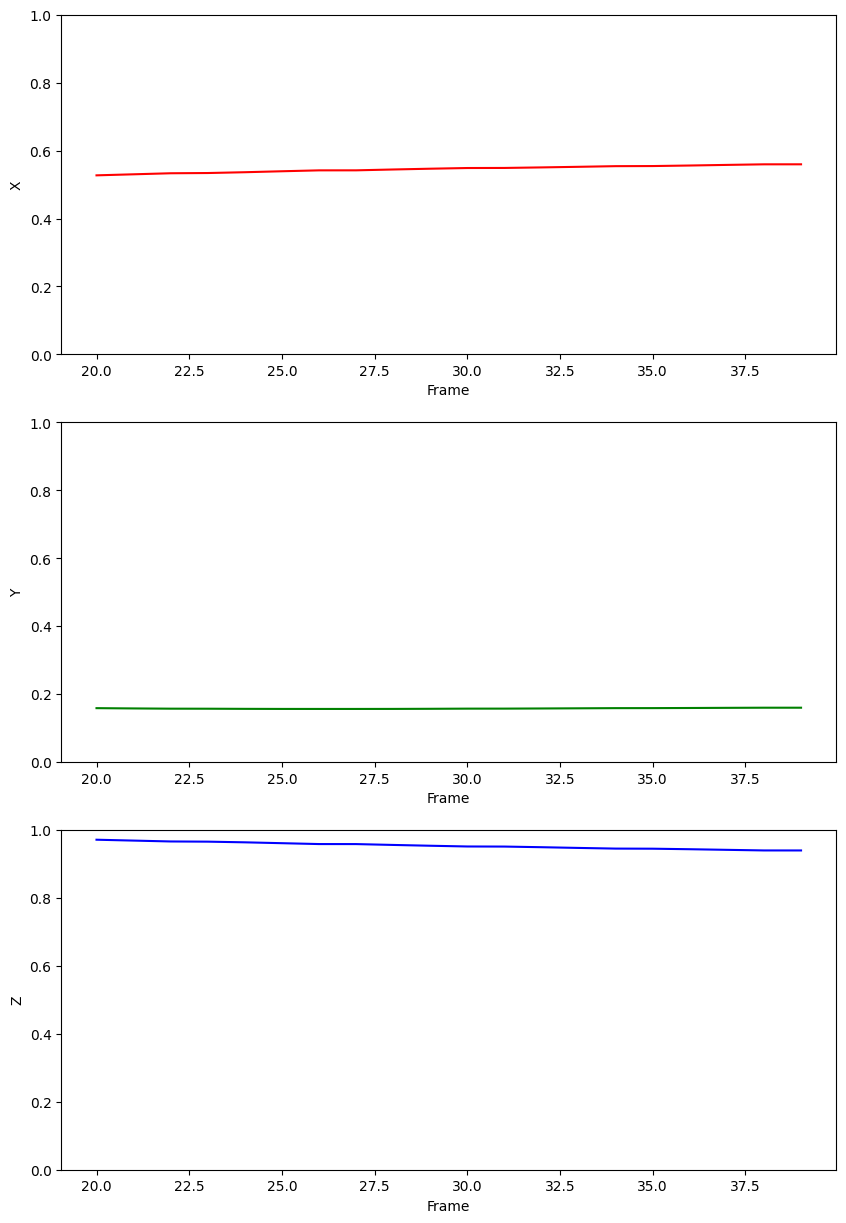

<Figure size 640x480 with 0 Axes>

In [50]:
#Same Particle_ids across Initial_Frames
def get_track(df, particle_id):
    track_df = df[df['Particle_id'] == particle_id]
    xpos = track_df['X_i'].values
    ypos = track_df['Y_i'].values
    zpos = track_df['Z_i'].values
    frames = track_df['Initial_Frame'].values
    fig = plt.figure(figsize=(10, 15))
    ax = fig.add_subplot(311)
    ax.plot(frames, xpos, 'r')
    ax.set_xlabel('Frame')
    ax.set_ylabel('X')
    ax.set_ylim([0,1])
    ax = fig.add_subplot(312)
    ax.plot(frames, ypos, 'g')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Y')
    ax.set_ylim([0,1])
    ax = fig.add_subplot(313)
    ax.plot(frames, zpos, 'b')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Z')
    ax.set_ylim([0,1])
    plt.show()
    plt.savefig('track_'+str(particle_id)+'.png')

get_track(df_timeseries_core, 1405)

In [42]:
def plot_data():
    fig = plt.figure(figsize=(4.5*len(FRAMES), 8))
    
    for frame_num_index in range(len(FRAMES)):
        df_this_frame = df_timeseries_core[df_timeseries_core['Initial_Frame']==FRAMES[frame_num_index]]
        ax = plt.subplot2grid((2,len(FRAMES)), (0,frame_num_index))
        ax.set_title(f'Frame: {FRAMES[frame_num_index]}', fontsize=18)
        ax.set_xlim(0, 1)
        ax.set_xlabel('X', fontsize=18)
        ax.set_ylim(0, 1)
        ax.set_ylabel('Y', fontsize=18)
        ax.scatter(df_this_frame['X_i'], df_this_frame['Y_i'], s=1e-4, color='red')

        ax = plt.subplot2grid((2,len(FRAMES)), (1,frame_num_index))
        ax.set_title(f'Frame: {FRAMES[frame_num_index]+FRAME_DIFF}', fontsize=18)
        ax.set_xlim(0, 1)
        ax.set_xlabel('X', fontsize=18)
        ax.set_ylim(0, 1)
        ax.set_ylabel('Y', fontsize=18)
        ax.scatter(df_this_frame['X_f'], df_this_frame['Y_f'], s=1e-4, color='royalblue')
        
    
    fig.tight_layout()
    plt.savefig('Core_Particles_All_Frames_Frame'+str(FRAMES[0])+'_to_Frame'+str(FRAMES[-1])+'.png')
    plt.show()

def plot_prediction(y_true,y_pred):
    fig = plt.figure(figsize=(12, 8))
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        ax.scatter(y_true[:,i], y_pred[:,i], c='crimson', s=1e-2)
        p1 = max(max(y_pred[:,i]), max(y_true[:,i]))
        p2 = min(min(y_pred[:,i]), min(y_true[:,i]))
        ax.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        ax.set_ylabel(TARGET[i])
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
    fig.tight_layout()
    plt.savefig('Core_Particles_All_Frames_Frame'+str(FRAMES[0])+'_to_Frame'+str(FRAMES[-1])+'_Prediction.png')
    plt.show()

#plot_data()

## Split data

In [4]:
X, y = df_timeseries_core[FEATURES], df_timeseries_core[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = NTEST_percentage,  random_state=seed)

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

## Train model

In [49]:
n_estimators    = 1000   #The number of trees in the ensemble, often increased until no further improvements are seen.
max_depth       = 7     #The maximum depth of each tree, often values are between 1 and 10.
eta             = 0.01  #The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
subsample       = 1/30 #The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
colsample_bytree= 1     #Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.
model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=eta, subsample=subsample, colsample_bytree=colsample_bytree)

#We will evaluate the model using the best practice of repeated k-fold cross-validation with 3 repeats and 10 folds.
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )


Mean MAE: 0.094 (0.000)


In [50]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=0.01, eval_metric=None, feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

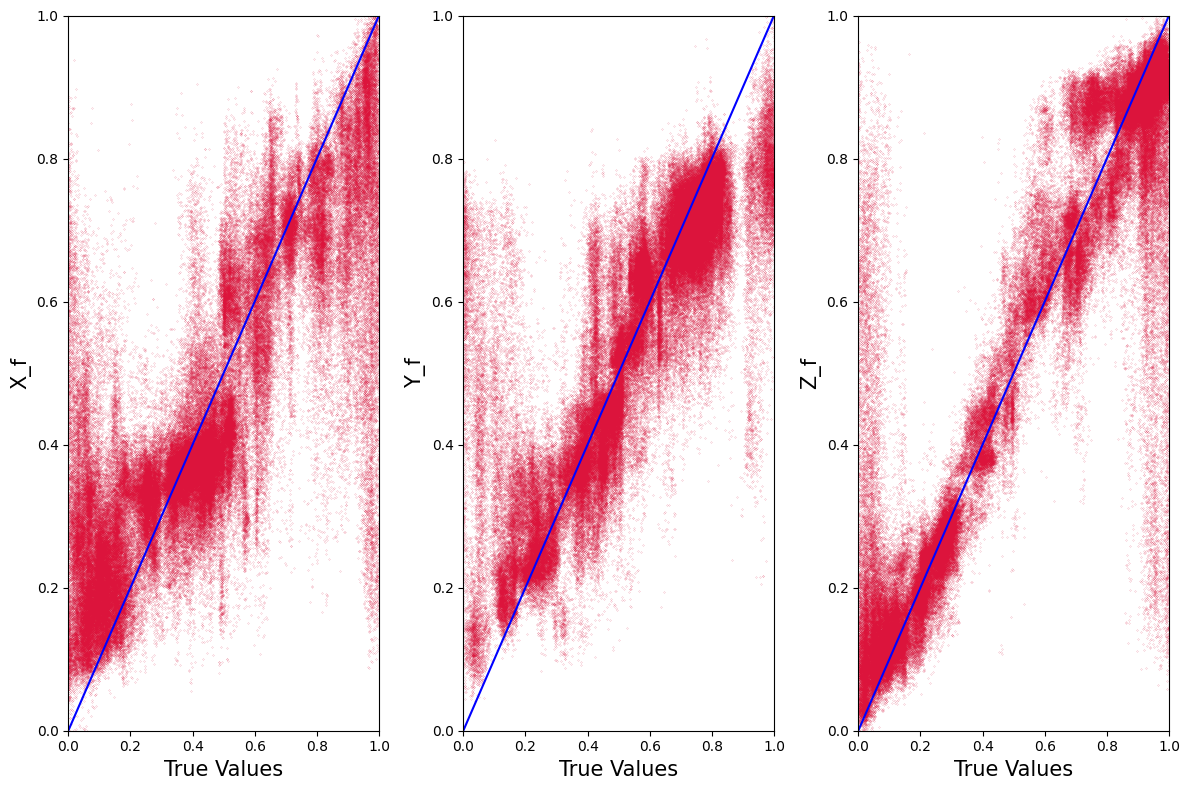

In [51]:
yhat = model.predict(X_test)
plot_prediction(y_test.to_numpy(),yhat)

In [24]:
#%%writefile nnmodel.py
def define_and_train_model(dtrain_reg, dtest_reg, n = 1000, cross_validation_nfold = 0):
    try:
        del model
    except:
        print("No model to delete")
    
    # Define hyperparameters
    params = {"objective": "reg:squarederror"}#, "tree_method": "gpu_hist"}
    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
    model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10, # Every ten rounds
    early_stopping_rounds=50, #Activate early stopping
    )
    print()
    if cross_validation_nfold>0:
        results = xgb.cv(
        params, dtrain_reg,
        num_boost_round=n,
        nfold=cross_validation_nfold,
        verbose_eval=10, # Every ten rounds
        early_stopping_rounds=50,
        )
        best_rmse = results['test-rmse-mean'].min()
        print(best_rmse)
    return model
model = define_and_train_model(dtrain_reg, dtest_reg)
visualize training and testing by frames

No model to delete
[0]	train-rmse:0.25043	validation-rmse:0.25055
[10]	train-rmse:0.16885	validation-rmse:0.16940
[20]	train-rmse:0.16038	validation-rmse:0.16104
[30]	train-rmse:0.15483	validation-rmse:0.15563
[40]	train-rmse:0.15093	validation-rmse:0.15189
[50]	train-rmse:0.14749	validation-rmse:0.14857
[60]	train-rmse:0.14446	validation-rmse:0.14564
[70]	train-rmse:0.14184	validation-rmse:0.14317
[80]	train-rmse:0.13996	validation-rmse:0.14135
[90]	train-rmse:0.13782	validation-rmse:0.13931
[100]	train-rmse:0.13592	validation-rmse:0.13755
[110]	train-rmse:0.13406	validation-rmse:0.13575
[120]	train-rmse:0.13262	validation-rmse:0.13438
[130]	train-rmse:0.13099	validation-rmse:0.13286
[140]	train-rmse:0.12937	validation-rmse:0.13132
[150]	train-rmse:0.12807	validation-rmse:0.13010
[160]	train-rmse:0.12650	validation-rmse:0.12859
[170]	train-rmse:0.12524	validation-rmse:0.12741
[180]	train-rmse:0.12409	validation-rmse:0.12636
[190]	train-rmse:0.12308	validation-rmse:0.12542
[200]	train-

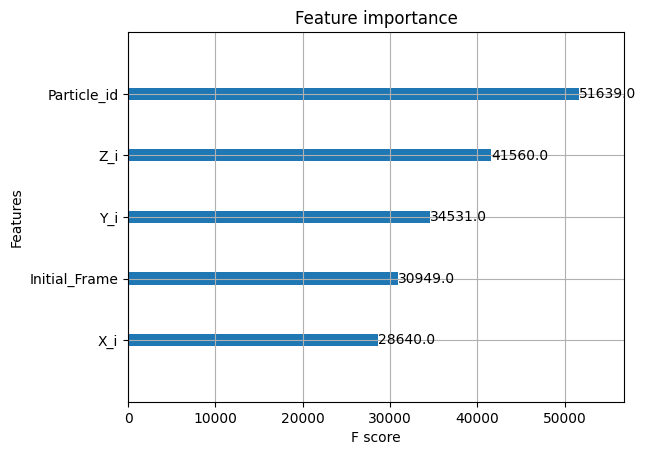

In [29]:
xgb.plot_importance(model)
plt.show()

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

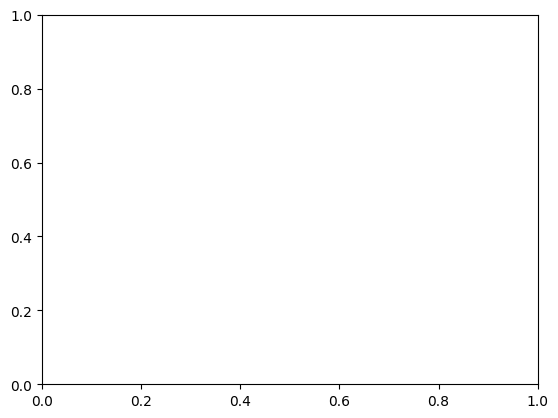

In [31]:
xgb.plot_tree(model, num_trees=0) 
plt.show()

In [27]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost Training and Validation Loss')
plt.show()

AttributeError: 'Booster' object has no attribute 'evals_result'

In [26]:
import sklearn.metrics as skm
# standard measures of model performance
preds = model.predict(dtest_reg)
preds_df = pd.DataFrame(preds, index=X_test.index)
#Core rmse
rmse = skm.mean_squared_error(y_test, preds_df)
r2 = skm.r2_score(y_test,preds_df)
print("For Cores, ",rmse,r2)


For Cores,  0.008913016176027683 0.8880540571805026


## Stats
### Max Depth, Default = 6
#### Reg: Mean Squared Error (~4 min to train)
- For Cores, $RMSE: 1019423.8676899462; R2:                   0.9963610195367045$
- For Non Cores, $RMSE: 691423.0340961919; R2: -2051313306989260.2$   
#### Reg: Mean Absolute Error   (~107 min to train)
For Cores,  7746916.249471188 0.9932377146982748
For Non Cores,  1261673.1667665534 -2461632269410218.0

#### Reg: Pseudo Huber Error, delta = 0.001 (~20s min to train)
For Cores,  5251149496.88155 -16153185246.33833
For Non Cores,  1215310709.10951 -3.0784832358542043e+39

### Max Depth=7
#### Reg: Mean Squared Error (~4 min to train)
For Cores,  747171.0932774782 0.9963633422429186
For Non Cores,  683128.8908151424 -2051313306989260.2 